In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cycle GAN
![Cycle-GAN](https://miro.medium.com/max/1838/0*S5gn5i6UhfyoRr9S.png)

## Step 1. Define Generator

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

## Step 2. Define Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

## Step 3. Define Loss

In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

## Step 4. Initalize G and D

In [6]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [7]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: False


## Step 5. Configure Optimizers

In [9]:
import itertools
lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

## Step 6. Learning Rate Scheduler Setting

In [10]:
n_epoches = 80
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)


## Step 7. DataLoader

In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ConvertToRGB:
    def __call__(self, img):
        if img.mode == 'RGBA':
            # Convert RGBA image to RGB
            img = img.convert('RGB')
        return img
        
class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, '{}A'.format(mode))
        B_dir = os.path.join(data_dir, '{}B'.format(mode))
    
        self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))]
        self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))]  
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)

    @property
    def min_len(self):
        return min(len(self.files_A), len(self.files_B))
    
    def __getitem__(self, index):
        file_A = self.files_A[index % self.min_len]
        file_B = self.files_B[index % self.min_len]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B



# Dataset

# CHANGE FILE PATH

In [12]:

# CHANGE ME CHANGE ME CHANGE ME!!!!
data_dir = 'C:/Users/natal/Desktop/cycle_gan_photos'

In [13]:
import torchvision.transforms as transforms


transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    ConvertToRGB(),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 5

traindataset = ImageDataset(data_dir, mode='train', transforms=transforms_)
testdataset = ImageDataset(data_dir, mode='test', transforms=transforms_)

trainloader = DataLoader(
    traindataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

testloader = DataLoader(
    testdataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)


## Step 8. Sample images to show

In [14]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    print(nrows)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

In [23]:
from datetime import datetime

def sample_dataset(model, dataset, mode=0, idx=0, save_path='output', n=4, figside=1.5):
    model.eval()

    _real = dataset
    if not isinstance(dataset, torch.Tensor):
        _real = torch.cat([dataset[_idx][mode].unsqueeze(0) for _idx in range(idx, idx+n)], dim=0)
    _real = _real.type(Tensor)
    _fake = model(_real).detach()
    
    nrows = _real.size(0)
    real = make_grid(_real, nrow=nrows, normalize=True)
    fake = make_grid(_fake, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real, fake), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*2))
    plt.imshow(image_grid)

    if save_path:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        os.makedirs(save_path, exist_ok=True)
        fp = os.path.join(save_path, '{}.jpg'.format(timestamp))
        plt.savefig(fp)
        print('Saved to path: {}'.format(os.path.abspath(fp)))

    plt.axis('off')
    plt.show()

    return _fake


## Step 9. Training

## Saving or reloading

In [19]:
import os
import torch

def save_models(models, folder_path, file_names):
    # Create the directory if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save each model
    for model, file_name in zip(models, file_names):
        # Get the class name of the model
        file_path = os.path.join(folder_path, f"{file_name}.pt")
        torch.save(model.state_dict(), file_path)

    print("Models saved successfully.")


def load_models(models, folder_path, file_names):
    # Load the state dicts for each model
    for model, file_name in zip(models, file_names):
        file_path = os.path.join(folder_path, f"{file_name}.pt")
        model.load_state_dict(torch.load(file_path))

    print("Models loaded successfully.")


#load_models([G_AB, G_BA, D_A, D_B], "_model_cyclegan_natalie_128/", ['G_AB', 'G_BA', 'D_A', 'D_B'])

In [ ]:
folder_path = "C:/Users/natal/Documents/jupiter school project (1)/_model_cyclegan_natalie_128"
save_models([G_AB, G_BA, D_A, D_B], folder_path, ['G_AB', 'G_BA', 'D_A', 'D_B'])

In [21]:
folder_path = "C:/Users/natal/Documents/jupiter school project (1)/_model_cyclegan_natalie_128"
load_models([G_AB, G_BA, D_A, D_B], folder_path, ['G_AB', 'G_BA', 'D_A', 'D_B'])

Models loaded successfully.


In [ ]:
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()

        print(f'--[Iter {i+1}]')
        print(f'--[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'--[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # test
    if (epoch+1) % 10 == 0:
        test_real_A, test_real_B = next(iter(testloader))
        sample_images(test_real_A, test_real_B)

        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    

--[Iter 1]
--[G loss: 10.208292007446289 | identity: 0.6120283603668213 GAN: 1.0285123586654663 cycle: 0.6119637489318848]
--[D loss: 0.6217347979545593 | D_A: 0.7636179327964783 D_B: 0.4798516631126404]
--[Iter 2]
--[G loss: 7.5389084815979 | identity: 0.4352642893791199 GAN: 0.6340637803077698 cycle: 0.47285234928131104]
--[D loss: 0.7911808490753174 | D_A: 0.6942662596702576 D_B: 0.8880953788757324]
--[Iter 3]
--[G loss: 7.367822647094727 | identity: 0.3302217721939087 GAN: 1.6830297708511353 cycle: 0.40336835384368896]
--[D loss: 1.6838513612747192 | D_A: 2.202548027038574 D_B: 1.1651546955108643]
--[Iter 4]
--[G loss: 6.96378231048584 | identity: 0.3862653374671936 GAN: 0.5102084279060364 cycle: 0.4522247314453125]
--[D loss: 0.4695484936237335 | D_A: 0.3996328115463257 D_B: 0.5394641757011414]
--[Iter 5]
--[G loss: 5.381345272064209 | identity: 0.312476247549057 GAN: 0.4517015218734741 cycle: 0.33672624826431274]
--[D loss: 0.4050428867340088 | D_A: 0.43605899810791016 D_B: 0.374

## Step 10. Generate Images

### Generating specifically from A to B

Saved to path: C:\Users\natal\Documents\GitHub\HKU_202324S2_DESN3002_ARCH7378\ScriptsForIndividual\Natalie\output\AtoB\2024-05-10_21-24-02.jpg


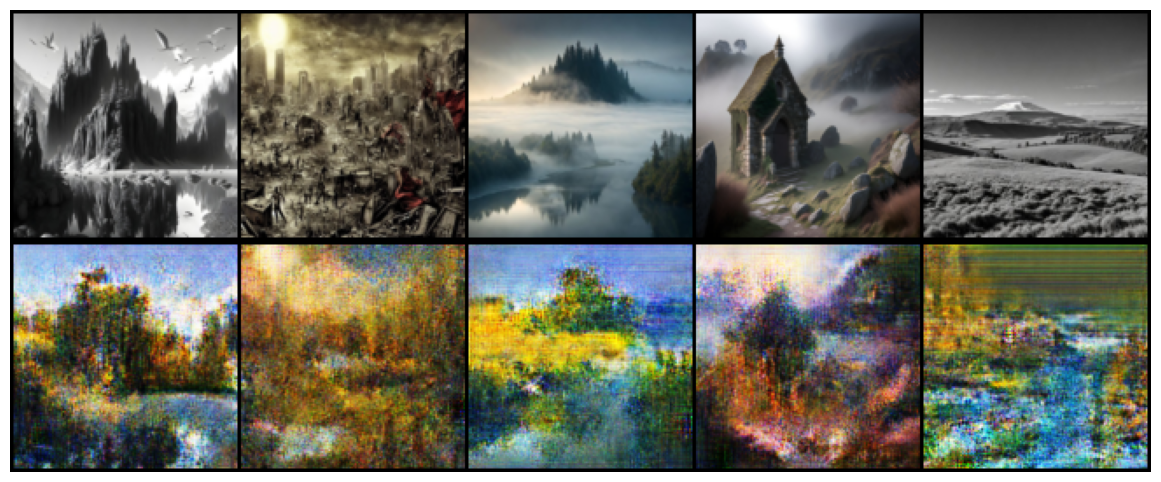

In [24]:
# A to B; 
# dataset mode: 0 = image domain A and 1 = image domain B
# idx: starting index of image in folder
# n: how many images
# figside: how big the image will 2
fake_B = sample_dataset(G_AB, traindataset, mode=0, idx=15, save_path='output/AtoB', figside=3, n=5)

Saved to path: /Users/tamk/Documents/GitHub/HKU/HKU_202324S2_DESN3002_ARCH7378/ScriptsForIndividual/GAN_General/output/ABtoA/2024-05-10_14-18-57.jpg


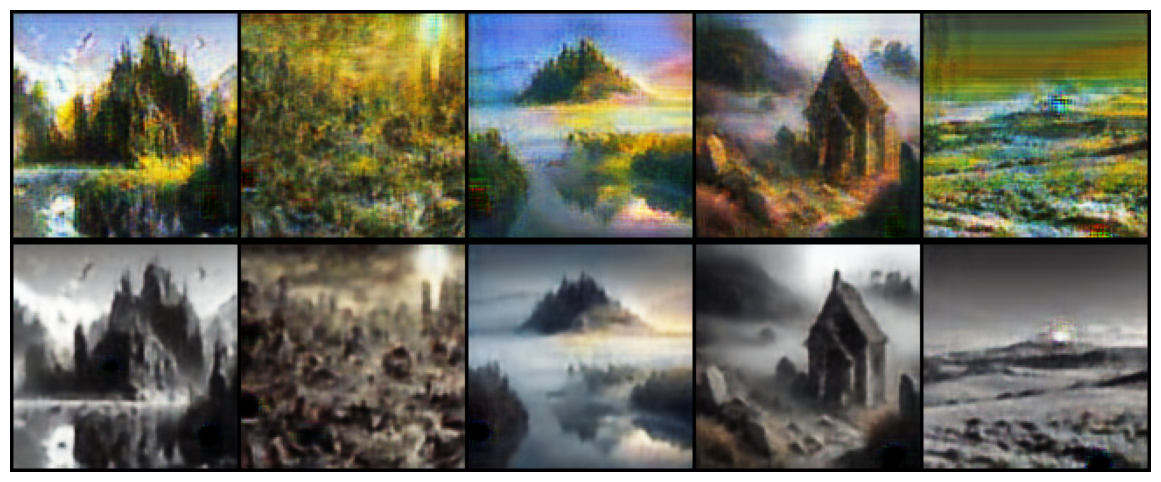

In [169]:
fake_BA = sample_dataset(G_BA, fake_B, save_path='output/ABtoA', figside=3, n=5)

Saved to path: /Users/tamk/Documents/GitHub/HKU/HKU_202324S2_DESN3002_ARCH7378/ScriptsForIndividual/GAN_General/output/ABB/2024-05-10_14-19-02.jpg


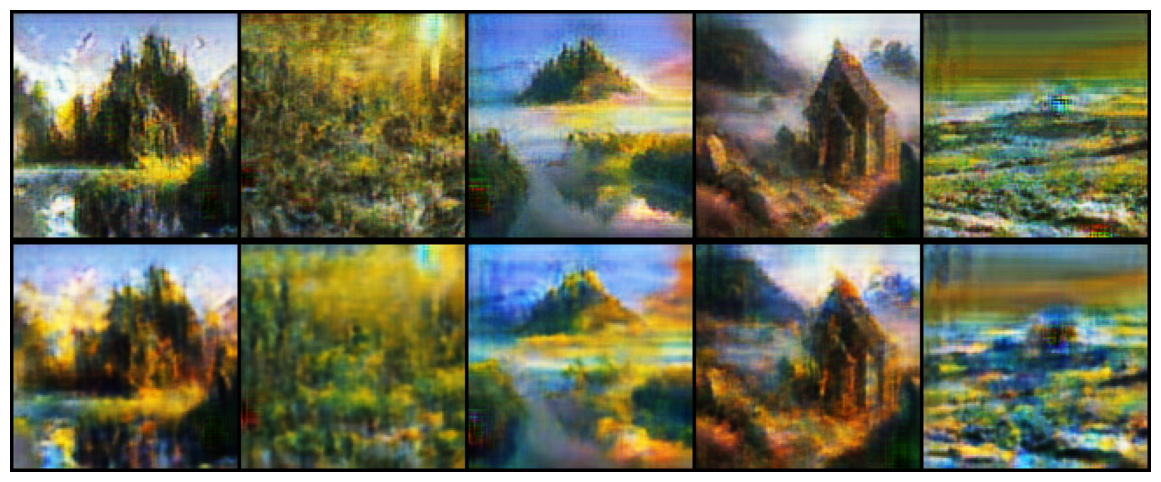

In [170]:
fake_ABB = sample_dataset(G_AB, fake_B, save_path='output/ABB', figside=3, n=5)

In [146]:
### Generating specifically from B to A

Saved to path: /Users/tamk/Documents/GitHub/HKU/HKU_202324S2_DESN3002_ARCH7378/ScriptsForIndividual/GAN_General/output/BtoA/2024-05-10_14-09-56.jpg


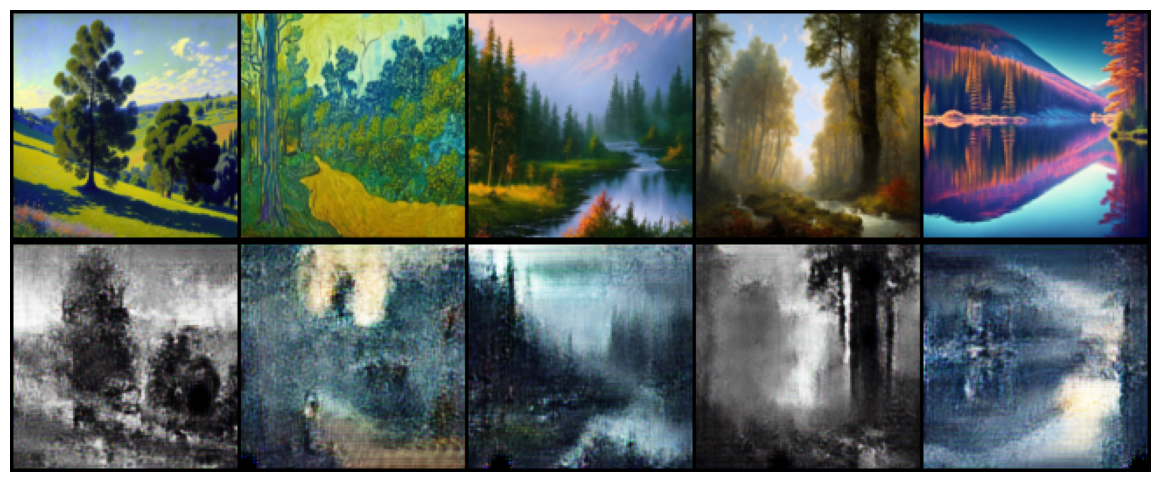

In [148]:
sample_dataset(G_BA, traindataset, mode=1, idx=0, save_path='output/BtoA', figside=3, n=5)

5


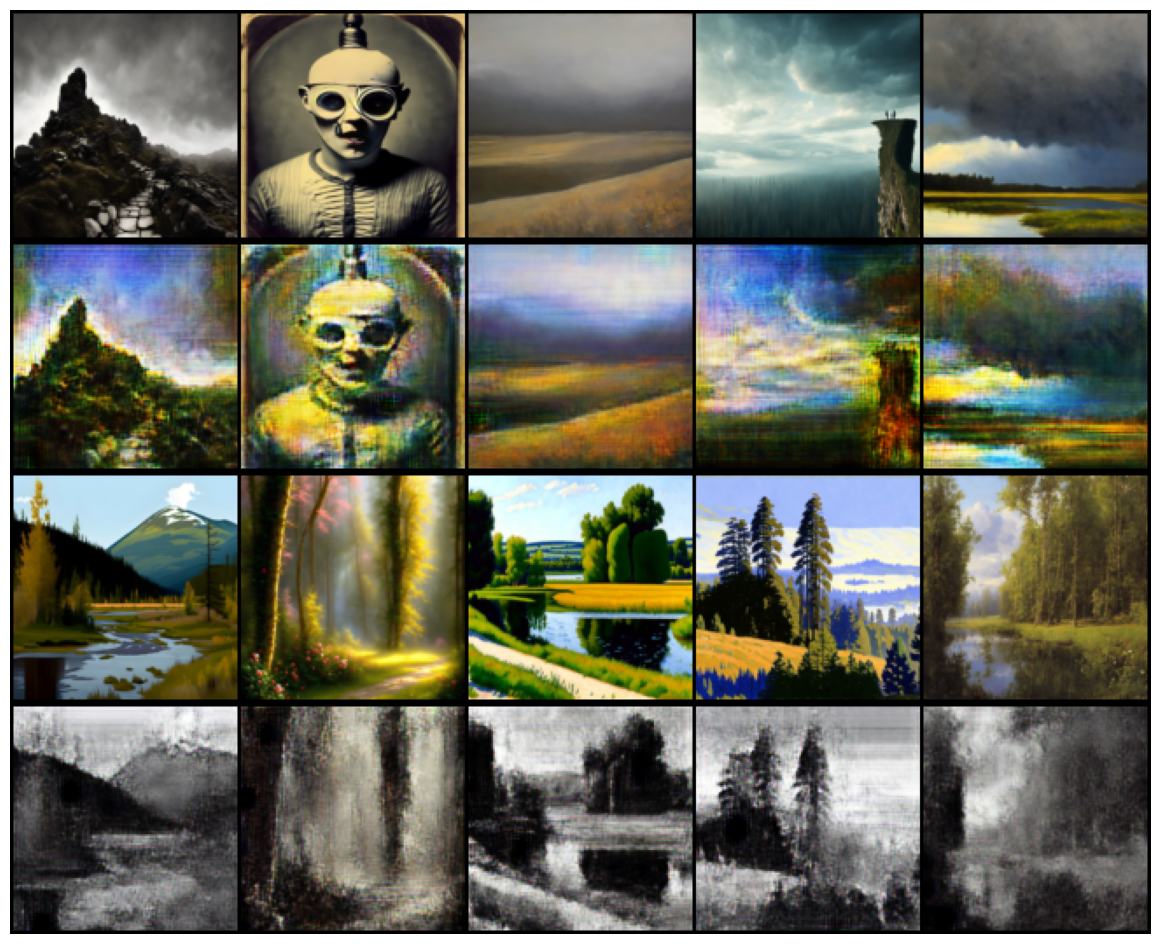

In [145]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B, figside=3)

5


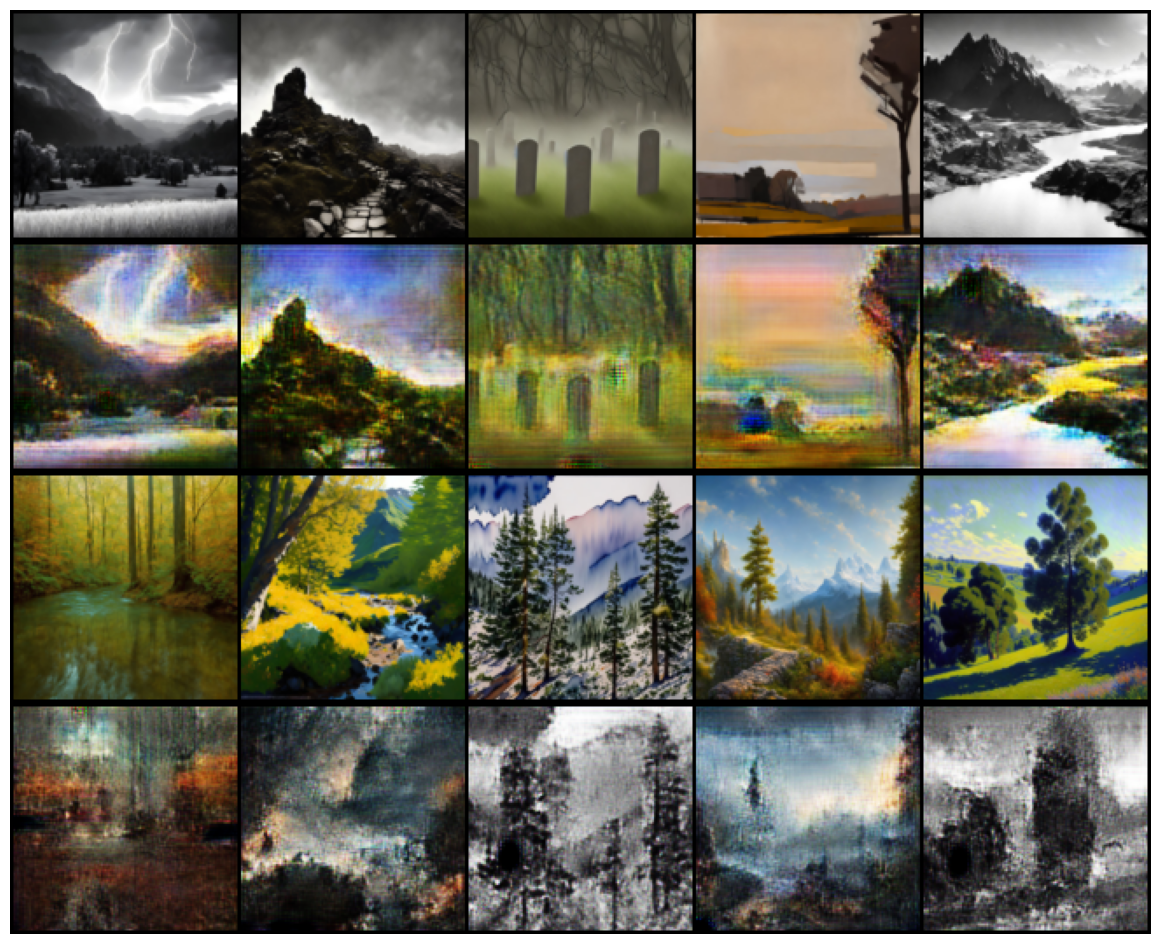

In [97]:
real_A, real_B = next(iter(trainloader))
sample_images(real_A, real_B, figside=3.)

In [15]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

7038

In [16]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [17]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_BA.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)
    
    # generate
    fake_imgs = G_BA(imgs).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [18]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'